# Time series to irradiance tutorial

In [1]:
%matplotlib inline
import sys
import os
#sys.path.append('..') #append the parent directory to the system path
import pvlib
import pandas as pd 
import matplotlib.pyplot as plt
try:
    import seaborn
    seaborn.set_context('paper')
except ImportError:
    pass

In [2]:
#20150621 cjw  datapath = os.path.join(pvlib.__path__[0], 'test', 'data')
datapath = os.path.join(pvlib.__path__[0], 'data')
fname = '703165TY.csv' #Use absolute path if the file is not in the local directory
TMY, meta = pvlib.tmy.readtmy3(filename=os.path.join(datapath, fname))
TMY.index.name = 'Time'
meta['SurfTilt'] = 30
meta['SurfAz'] = 0
meta['Albedo'] = 0.2

# create pvlib Location object
sand_point = pvlib.location.Location(meta['latitude'], meta['longitude'], tz='US/Alaska', 
                                     altitude=meta['altitude'], name=meta['Name'].replace('"',''))
print(sand_point)

# TMY data seems to be given as hourly data with time stamp at the end
# shift the index 30 Minutes back for calculation of sun postions
TMY = TMY.shift(freq='-30Min')

SAND POINT: latitude=55.317, longitude=-160.517, tz=US/Alaska, altitude=7.0


# Retrieve required parameters

Calculate the solar position for all times in the TMY file. Requires either PyEphem or a compiled spa_c library.

In [3]:
solpos = pvlib.solarposition.get_solarposition(TMY.index, sand_point, method='pyephem')
solpos.head()

pvlib.solarosition.pyephem: sun_coords['apparent_zenith']  #cjwcjw
Time
1997-01-01 09:30:00+00:00    144.750103
1995-02-12 01:30:00+00:00     76.326134
2005-03-25 17:30:00+00:00     82.235607
1999-05-06 09:30:00+00:00    106.764817
1996-06-17 01:30:00+00:00     44.271436
1991-07-28 17:30:00+00:00     68.596417
1996-09-08 09:30:00+00:00    117.476162
1999-10-20 01:30:00+00:00     75.673436
2005-11-30 17:30:00+00:00     99.774990
Name: apparent_zenith, dtype: float64


,apparent_elevation,apparent_azimuth,elevation,azimuth,apparent_zenith,zenith
Time,,,,,,
1997-01-01 00:30:00-09:00,-54.750103,328.861096,-54.750103,328.861096,144.750103,144.750103
1997-01-01 01:30:00-09:00,-57.530205,353.265280,-57.530205,353.265280,147.530205,147.530205
1997-01-01 02:30:00-09:00,-56.627712,18.751764,-56.627712,18.751764,146.627712,146.627712
1997-01-01 03:30:00-09:00,-52.329549,41.456666,-52.329549,41.456666,142.329549,142.329549
1997-01-01 04:30:00-09:00,-45.717933,60.026503,-45.717933,60.026503,135.717933,135.717933


In [4]:
# append solar position data to TMY DataFrame
TMY['SunAz'] = solpos['apparent_elevation']
TMY['SunZen'] =  solpos['apparent_zenith']

TMY['HExtra'] = pvlib.irradiance.extraradiation(datetime_or_doy=TMY.index.dayofyear)

TMY['AM'] = pvlib.atmosphere.relativeairmass(zenith=TMY.SunZen)

DFOut = pvlib.irradiance.disc(times=TMY.index, ghi=TMY.GHI, zenith=TMY.SunZen)

TMY['DNI_gen_DISC'] = DFOut['dni']
TMY['Kt_gen_DISC'] = DFOut['kt']
TMY['AM'] = DFOut['airmass']
# TMY['Ztemp'] = DFOut['Ztemp']

pvlib.atmosphere.relativeairmass: zenith input z  #cjwcjw
Time
1997-01-01 00:30:00-09:00    144.750103
1997-01-05 04:30:00-09:00    135.602400
1997-01-09 08:30:00-09:00    102.432447
1997-01-13 12:30:00-09:00     78.512732
1997-01-17 16:30:00-09:00     82.820808
1997-01-21 20:30:00-09:00    111.182018
1997-01-26 00:30:00-09:00    139.979530
1997-01-30 04:30:00-09:00    132.198220
1995-02-03 08:30:00-09:00     98.789525
1995-02-07 12:30:00-09:00     72.822607
1995-02-11 16:30:00-09:00     76.326134
1995-02-15 20:30:00-09:00    105.037372
1995-02-20 00:30:00-09:00    132.610466
1995-02-24 04:30:00-09:00    125.033625
1995-02-28 08:30:00-09:00     90.779356
2005-03-04 12:30:00-09:00     63.830813
2005-03-08 16:30:00-09:00     68.000330
2005-03-12 20:30:00-09:00     97.815052
2005-03-17 00:30:00-09:00    123.504595
2005-03-21 04:30:00-09:00    115.388394
2005-03-25 08:30:00-09:00     82.235607
2005-03-29 12:30:00-09:00     53.883251
2005-04-02 16:30:00-09:00     59.809867
2005-04-06 20:30:

# Perez

In [5]:
models = ['Perez', 'Hay-Davies', 'Isotropic', 'King', 'Klucher', 'Reindl']
TMY['Perez'] = pvlib.irradiance.perez(surface_tilt=meta['SurfTilt'],
                               surface_azimuth=meta['SurfAz'],
                               dhi=TMY.DHI,
                               dni=TMY.DNI,
                               dni_extra=TMY.HExtra,
                               solar_zenith=TMY.SunZen,
                               solar_azimuth=TMY.SunAz,
                               airmass=TMY.AM)

## HayDavies

In [6]:
TMY['Hay-Davies'] = pvlib.irradiance.haydavies(surface_tilt=meta['SurfTilt'],
                                            surface_azimuth=meta['SurfAz'],
                                            dhi=TMY.DHI,
                                            dni=TMY.DNI,
                                            dni_extra=TMY.HExtra,
                                            solar_zenith=TMY.SunZen,
                                            solar_azimuth=TMY.SunAz)                                

## Isotropic

In [7]:
TMY['Isotropic'] = pvlib.irradiance.isotropic(surface_tilt=meta['SurfTilt'],
                                          dhi=TMY.DHI)

## King Diffuse model

In [8]:
TMY['King'] = pvlib.irradiance.king(surface_tilt=meta['SurfTilt'],
                                    dhi=TMY.DHI,
                                    ghi=TMY.GHI,
                                    solar_zenith=TMY.SunZen)

## Klucher Model

In [9]:
TMY['Klucher'] = pvlib.irradiance.klucher(surface_tilt=meta['SurfTilt'],
                                       surface_azimuth=meta['SurfAz'],
                                       dhi=TMY.DHI,
                                       ghi=TMY.GHI,
                                       solar_zenith=TMY.SunZen,
                                       solar_azimuth=TMY.SunAz)                                

## Reindl

In [10]:
TMY['Reindl'] = pvlib.irradiance.reindl(surface_tilt=meta['SurfTilt'],
                                     surface_azimuth=meta['SurfAz'],
                                     dhi=TMY.DHI,
                                     dni=TMY.DNI,
                                     ghi=TMY.GHI,
                                     dni_extra=TMY.HExtra,
                                     solar_zenith=TMY.SunZen,
                                     solar_azimuth=TMY.SunAz)

In [11]:
yearly = TMY[models].resample('A', how='sum').squeeze() / 1000.0  # kWh
monthly = TMY[models].resample('M', how='sum', kind='period') / 1000.0
daily = TMY[models].resample('D', how='sum') / 1000.0

## Plot Results

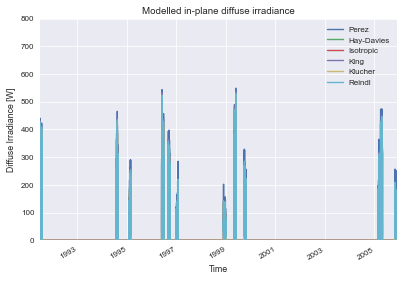

In [12]:
ax = TMY[models].plot(title='Modelled in-plane diffuse irradiance');
# ax.legend(ncol=3, loc='upper center', title='In-plane diffuse irradiance')
ax.set_ylim(0, 800);
ylabel = ax.set_ylabel('Diffuse Irradiance [W]');

In [13]:
TMY[models].describe()

,Perez,Hay-Davies,Isotropic,King,Klucher,Reindl
count,4131.000000,8760.000000,8760.000000,8760.000000,8760.000000,4578.000000
mean,122.731443,54.459532,49.094681,53.066640,49.094681,104.604617
std,78.409381,75.965638,72.134083,76.339057,72.134083,76.938499
min,6.531089,0.000000,0.000000,0.000000,0.000000,0.000000
25%,62.511851,0.000000,0.000000,0.000000,0.000000,45.717622
50%,109.360697,4.665064,3.732051,4.009799,3.732051,93.301270
75%,165.621806,97.784913,81.172105,91.753825,81.172105,147.995397
max,548.683520,527.692225,523.420126,538.818466,523.420126,530.560094


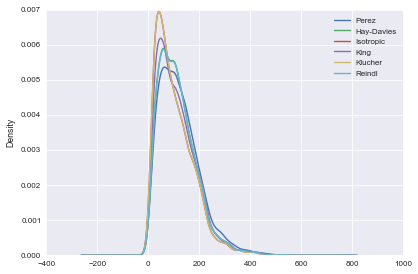

In [14]:
TMY[models].dropna().plot(kind='density');

In [15]:
# print(daily[models]).head()

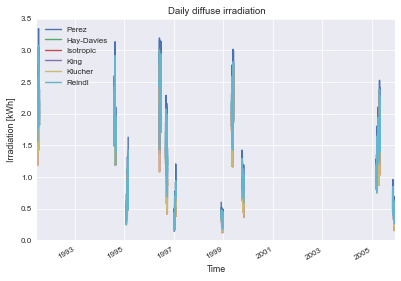

In [16]:
#had to remove the timezone to make this plot works
daily[models].index.tz = None
ax_daily = daily[models].plot(title='Daily diffuse irradiation');
ylabel = ax_daily.set_ylabel('Irradiation [kWh]');

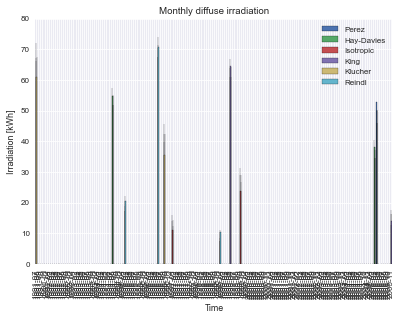

In [17]:
ax_monthly = monthly[models].plot(title='Monthly diffuse irradiation', kind='bar');
ylabel = ax_monthly.set_ylabel('Irradiation [kWh]');

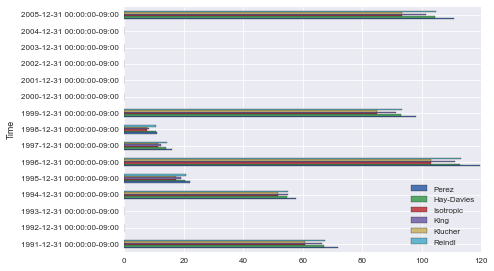

In [18]:
yearly.plot(kind='barh');

### Compute the mean deviation from average for each model and display as a function of the model

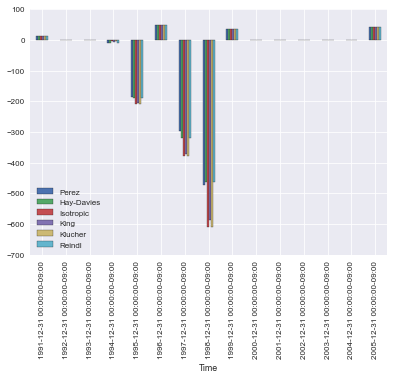

In [19]:
mean_yearly = yearly.mean()
yearly_mean_deviation = (yearly - mean_yearly) / yearly * 100.0
yearly_mean_deviation.plot(kind='bar');

## Python and [module versions, and dates](http://nbviewer.ipython.org/github/jrjohansson/scientific-python-lectures/blob/master/Lecture-0-Scientific-Computing-with-Python.ipynb)

In [20]:
%load_ext version_information
%version_information numpy, scipy, matplotlib, pandas, pvlib

Software versions
Python 2.7.8 32bit [MSC v.1500 32 bit (Intel)]
IPython 3.2.0
OS Windows 7 6.1.7601 SP1
numpy 1.9.2
scipy 0.15.1
matplotlib 1.4.3
pandas 0.16.2
pvlib 0.2.1dev
Sun Jul 12 14:28:45 2015 South Africa Standard Time